# Trabajo: Eliminación de artefactos impulsivos en una imagen

<small>William Fabian Arevalo rodriguez</small>

![Median filter](https://upload.wikimedia.org/wikipedia/commons/a/ae/Median_filter_2D.gif)
Median Filter
<small><hr>Source https://commons.wikimedia.org/wiki/File:Median_filter_2D.gif</small>

In [1]:
# Import libraries
import numpy as np
import sklearn as sk
import skimage as ski
import matplotlib.pyplot as plt
import random
%matplotlib inline
print(f'numpy v.{np.__version__}\
\nsklearn v.{sk.__version__}\
\nskimage v.{ski.__version__}')

numpy v.1.18.1
sklearn v.0.22.1
skimage v.0.16.2


In [2]:
# Load a img
img = ski.data.astronaut()

Img shape (512, 512, 3)


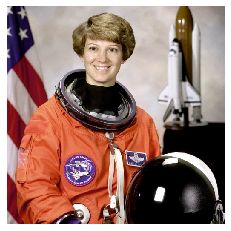

In [3]:
#Show img
plt.axis('off')
plt.imshow(img);
print(f'Img shape {img.shape}')

Img shape (512, 512)


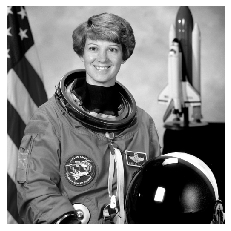

In [4]:
# Convert Color to gray (rgb2gray)
grays_img = ski.color.rgb2gray(img)
plt.axis('off')
plt.imshow(grays_img, cmap=plt.cm.gray);
print(f'Img shape {grays_img.shape}')

### 1. Crear una función que modele la adición, de forma aleatoria, de artefactos impulsivos. El resultado deberá apreciarse en la visualización de la imagen, que deberá estar afectada por ruido de tipo «sal y pimienta». Como se ha visto en la asignatura, estos artefactos toman valores de intensidad máximos o mínimos, y afectan, aleatoriamente, a los píxeles de la imagen. La función a implementar debe aceptar la imagen original y devolver la imagen afectada por el ruido. Además, sería deseable que aceptara un argumento adicional para indicar el porcentaje de píxeles que se verán afectados por estos artefactos. 

In [5]:
# Build a function for add noise to a img
def add_noise(img, noise=None):
    """Add random noise
input:
img: 1d or 3d imagen
noise: float in range [0,1]
output:
return image with noise"""
    if noise is None:
        noise = random.random()*0.01
    return ski.util.random_noise(img, mode='s&p', amount=noise)

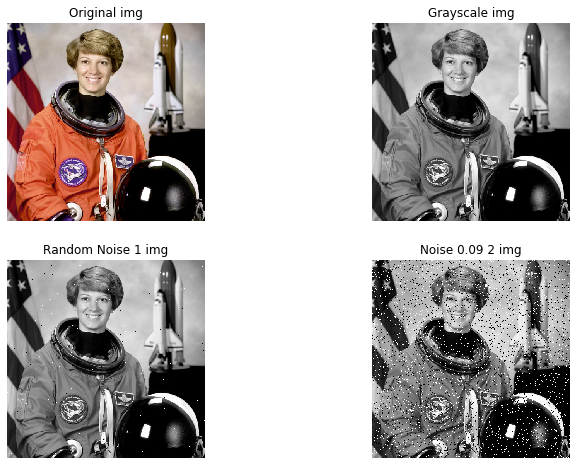

In [6]:
# Grid of img and transformations
plt.figure(figsize=(12,8))
# Original
plt.subplot(2,2,1)
plt.axis('off')
plt.title("Original img")
plt.imshow(img, cmap=plt.cm.gray)
# Gray
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Grayscale img")
plt.imshow(grays_img, cmap=plt.cm.gray)
# Random Noise 1
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Random Noise 1 img")
plt.imshow(add_noise(grays_img), cmap=plt.cm.gray)
# Random Noise 2
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Noise 0.09 2 img")
plt.imshow(add_noise(grays_img, 0.09), cmap=plt.cm.gray);

### A partir de la imagen ruidosa, buscaremos eliminar los artefactos impulsivos para el posterior tratamiento de la imagen. Para ello, se deberá aplicar un filtro adecuado para este tipo de ruido

In [7]:
# Import methods for denoise
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

In [18]:
# Estimate the average noise standard deviation.
# Note : With multichannel in True is for rgb img
noise = 0.05
noisy_gray_img = add_noise(grays_img, noise)
sigma_est = estimate_sigma(noisy_gray_img, multichannel=False, average_sigmas=True)
print(f'Real noise rate {noise} and estimated Gaussian noise {sigma_est:.3f} \
      \nMaybe gaussian is no the best because s&p is diff to gaussian method')

Real noise rate 0.05 and estimated Gaussian noise 0.029       
Maybe gaussian is no the best because s&p is diff to gaussian method


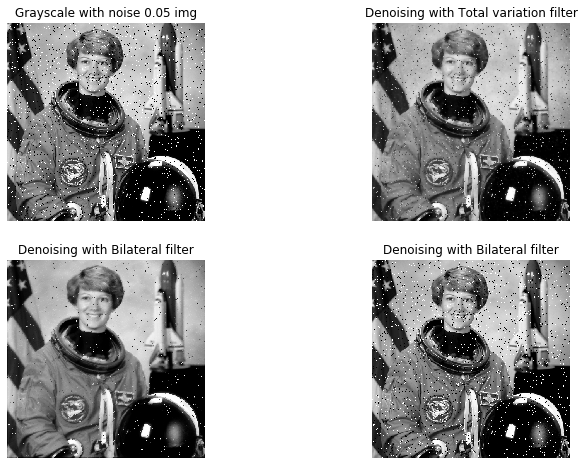

In [19]:
# Grid of methods for denoise Statistical
plt.figure(figsize=(12,8))
# Noise Gray
plt.subplot(2,2,1)
plt.axis('off')
plt.title(f"Grayscale with noise {noise} img")
plt.imshow(noisy_gray_img, cmap=plt.cm.gray)
# Total variation filter
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Denoising with Total variation filter")
plt.imshow(denoise_tv_chambolle(noisy_gray_img), cmap=plt.cm.gray)
# Bilateral filter
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Denoising with Bilateral filter")
plt.imshow(denoise_bilateral(noisy_gray_img), cmap=plt.cm.gray)
# Wavelet denoising filter
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Denoising with wavelet filter")
plt.imshow(denoise_wavelet(noisy_gray_img, rescale_sigma=False), cmap=plt.cm.gray);

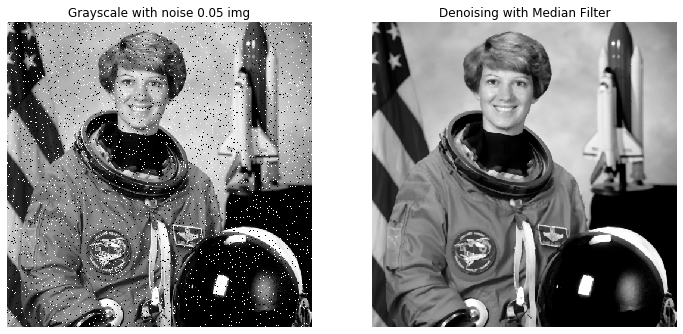

In [29]:
# Median filter
import skimage.filters as filters
from skimage.morphology import disk #this is for the size of the frame
# Grid of filters for denoise
plt.figure(figsize=(12,8))
# Noise Gray
plt.subplot(1,2,1)
plt.axis('off')
plt.title(f"Grayscale with noise {noise} img")
plt.imshow(noisy_gray_img, cmap=plt.cm.gray)
# Median filter
plt.subplot(1,2,2)
plt.axis('off')
plt.title("Denoising with Median Filter")
plt.imshow(filters.rank.median(noisy_gray_img), cmap=plt.cm.gray); # Frame of 3 pixels by default

### Por último, a partir de la imagen obtenida en la etapa anterior, se busca identificar las siluetas de las estructuras en ella presentes. Para este fin, se debe identificar y razonar qué tipo de operador corresponde aplicar.

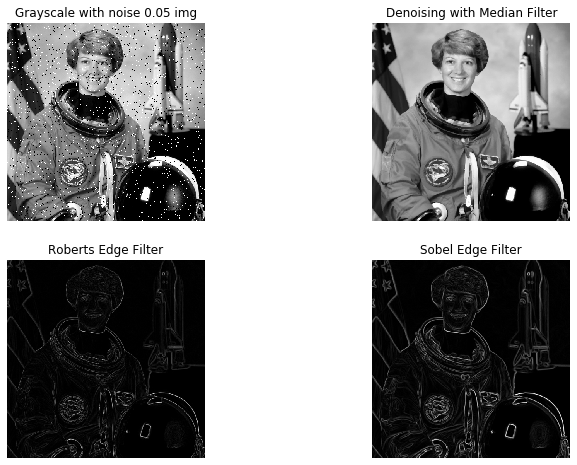

In [32]:
#Un filtro de borde es ideal(edges)
denoise_img = filters.rank.median(noisy_gray_img)
# Grid of edge filters
# Noise gray img
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.axis('off')
plt.title(f"Grayscale with noise {noise} img")
plt.imshow(noisy_gray_img, cmap=plt.cm.gray)
# Median filter
plt.subplot(2,2,2)
plt.axis('off')
plt.title("Denoising with Median Filter")
plt.imshow(denoise_img, cmap=plt.cm.gray) # Frame of 3 pixels by default
# Roberts Edge filter
plt.subplot(2,2,3)
plt.axis('off')
plt.title("Roberts Edge Filter")
plt.imshow(filters.roberts(denoise_img), cmap=plt.cm.gray)
# Sobel Edge filter
plt.subplot(2,2,4)
plt.axis('off')
plt.title("Sobel Edge Filter")
plt.imshow(filters.sobel(denoise_img), cmap=plt.cm.gray);


# End